## Medical Recommendation System with Machine Learning

# Description:
Welcome to our cutting-edge Personalized Medical Recommendation System, a powerful platform designed to assist users in understanding and managing their health. Leveraging the capabilities of machine learning, our system analyzes user-input symptoms to predict potential diseases accurately.

In [1]:
# inport libraries and models :: 
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
# load all datasets
data = pd.read_csv("datasets/training.csv")
symtoms = pd.read_csv("datasets/symtoms.csv")
precautions = pd.read_csv("datasets/precautions.csv")
workout = pd.read_csv("datasets/workout.csv")
description = pd.read_csv("datasets/description.csv")
medications = pd.read_csv("datasets/medications.csv")
diets = pd.read_csv("datasets/diets.csv")

In [3]:
print(data.head())

   itching  skin_rash  nodal_skin_eruptions  continuous_sneezing  shivering  \
0        1          1                     1                    0          0   
1        0          1                     1                    0          0   
2        1          0                     1                    0          0   
3        1          1                     0                    0          0   
4        1          1                     1                    0          0   

   chills  joint_pain  stomach_pain  acidity  ulcers_on_tongue  ...  \
0       0           0             0        0                 0  ...   
1       0           0             0        0                 0  ...   
2       0           0             0        0                 0  ...   
3       0           0             0        0                 0  ...   
4       0           0             0        0                 0  ...   

   blackheads  scurring  skin_peeling  silver_like_dusting  \
0           0         0             

In [4]:
print(data.isnull().sum())

itching                 0
skin_rash               0
nodal_skin_eruptions    0
continuous_sneezing     0
shivering               0
                       ..
inflammatory_nails      0
blister                 0
red_sore_around_nose    0
yellow_crust_ooze       0
prognosis               0
Length: 133, dtype: int64


In [5]:
# Combine numerical, encoded categorical, and polynomial features
X = data.iloc[:, :-1]  # All symptom columns
y = data["prognosis"]  # Target column (disease names)

In [6]:
# Convert target variable y to numeric values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Convert categorical labels to numbers

In [7]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
# Remove Highly Correlated Features
df = pd.DataFrame(X_train)  # Convert to DataFrame
correlation_matrix = df.corr().abs()

# Remove features with high correlation (>0.9)
high_correlation_features = correlation_matrix[correlation_matrix > 0.9].sum()
print(high_correlation_features)

itching                 1.000000
skin_rash               1.000000
nodal_skin_eruptions    1.000000
continuous_sneezing     1.000000
shivering               1.000000
                          ...   
small_dents_in_nails    3.821329
inflammatory_nails      3.821329
blister                 2.878794
red_sore_around_nose    2.878794
yellow_crust_ooze       2.885561
Length: 132, dtype: float64


In [9]:
print(X_train.head())

      itching  skin_rash  nodal_skin_eruptions  continuous_sneezing  \
682         0          0                     0                    0   
3963        0          0                     0                    0   
3126        0          0                     0                    0   
4480        0          0                     0                    0   
3411        0          0                     0                    0   

      shivering  chills  joint_pain  stomach_pain  acidity  ulcers_on_tongue  \
682           0       1           0             0        0                 0   
3963          0       1           0             0        0                 0   
3126          0       0           0             0        0                 0   
4480          0       0           0             0        1                 0   
3411          0       0           0             0        0                 0   

      ...  pus_filled_pimples  blackheads  scurring  skin_peeling  \
682   ...              

In [10]:
print(X_test.head())

      itching  skin_rash  nodal_skin_eruptions  continuous_sneezing  \
373         0          1                     0                    0   
4916        0          1                     0                    0   
1550        0          0                     0                    0   
3081        0          0                     0                    0   
3857        1          0                     0                    0   

      shivering  chills  joint_pain  stomach_pain  acidity  ulcers_on_tongue  \
373           0       0           0             0        0                 0   
4916          0       0           0             0        0                 0   
1550          0       0           0             0        0                 0   
3081          0       0           0             0        0                 0   
3857          0       0           0             0        0                 0   

      ...  pus_filled_pimples  blackheads  scurring  skin_peeling  \
373   ...              

In [11]:
y_train_series = pd.Series(y_train)
print(y_train_series.head())  # Now works correctly


0    34
1    34
2    23
3    30
4    17
dtype: int64


In [12]:
#  Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [13]:
# colleaction of all models  
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=10),
    "Lasso Regression": Lasso(alpha=0.1),
    "Decision Tree": DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5),
    "Random Forest": RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "AdaBoost Regressor": AdaBoostRegressor(n_estimators=50, random_state=42),
    "Support Vector Regression (SVR)": SVR(kernel="rbf"),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=20),
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
}

In [14]:
# Dictionary to store results
results = [] # store the R² Score, MAE, MSE values

r2_scores = [] # store the R² Score

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train_scaled, y_train)  # Train model
    y_pred = model.predict(X_test_scaled)  # Predict on test data
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    # Store results
    results.append([name, r2, mae, mse])
    r2_scores.append(r2)

# Convert results to DataFrame and print
results_df = pd.DataFrame(results, columns=["Model", "R² Score", "MAE", "MSE"])

print(results_df)

                             Model  R² Score       MAE        MSE
0                Linear Regression  0.972239  1.135381   3.844955
1                 Ridge Regression  0.972252  1.139888   3.843191
2                 Lasso Regression  0.965433  1.243587   4.787689
3                    Decision Tree  0.477857  6.180219  72.318356
4                    Random Forest  0.831827  2.927731  23.292470
5                Gradient Boosting  0.915484  2.935051  11.705731
6               AdaBoost Regressor  0.328043  8.196915  93.068187
7  Support Vector Regression (SVR)  0.981686  0.665783   2.536554
8              K-Nearest Neighbors  0.997657  0.031233   0.324465
9                          XGBoost  0.976049  1.113402   3.317350


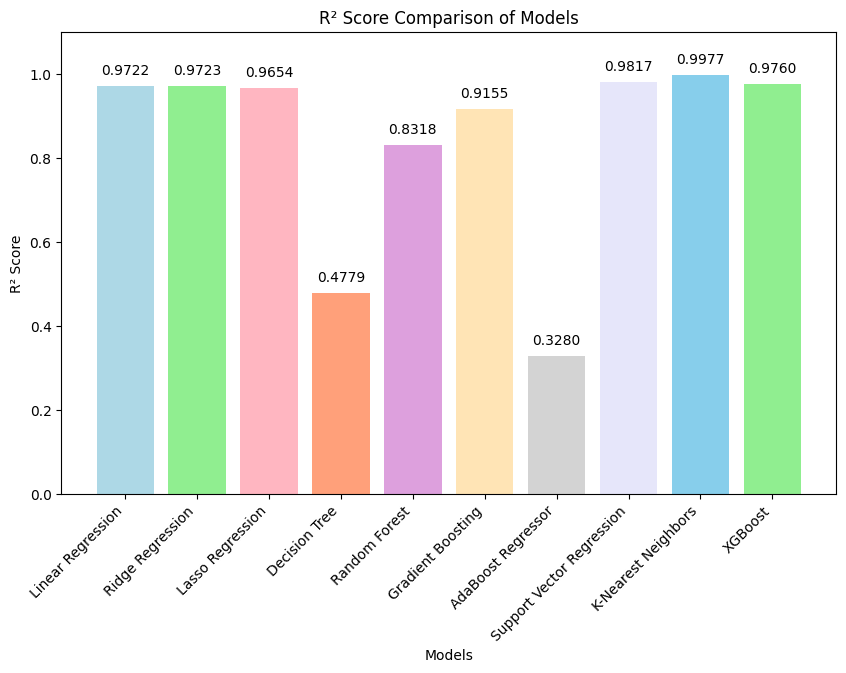

In [15]:
# Data for models and their R² scores
models = [
    'Linear Regression', 'Ridge Regression', 'Lasso Regression', 
    'Decision Tree', 'Random Forest', 'Gradient Boosting', 
    'AdaBoost Regressor', 'Support Vector Regression', 'K-Nearest Neighbors', 'XGBoost'
]

# Creating a bar chart
plt.figure(figsize=(10, 6))
colors = ["lightblue", "lightgreen", "lightpink", "lightsalmon", 
          "plum", "moccasin", "lightgray", "lavender", "skyblue", "lightgreen"]

plt.bar(models, r2_scores, color=colors)

plt.title('R² Score Comparison of Models')
plt.xlabel('Models')
plt.ylabel('R² Score')

# Displaying the R² scores on top of the bars
for i, score in enumerate(r2_scores):
    plt.text(i, score + 0.02, f'{score:.4f}', ha='center', va='bottom')

plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.1) 

plt.show()

In [ ]:
## Single prediction
# xgb prediction :
xgb = XGBRegressor(objective='reg:squarederror', booster='gbtree')
xgb.fit(X_train, y_train)
ypred = xgb.predict(X_test)
print("R2 Score:", r2_score(y_test, ypred))

# Ensure the directory exists
model_dir = "model"
os.makedirs(model_dir, exist_ok=True)

# saving model
model_path = os.path.join(model_dir, "xgb_regressor.pkl")
pickle.dump(xgb, open(model_path, 'wb'))

# load model
xgb = pickle.load(open(model_path, 'rb'))

# test 1 :
print("Predicted level:", xgb.predict(X_test.iloc[0].values.reshape(1, -1)))
print("Actual level:", y_test[0])

# test 2 :
print("Predicted level:", xgb.predict(X_test.iloc[10].values.reshape(1, -1)))
print("Actual level:", y_test[14])

R2 Score: 0.9993914365768433
Predicted level: [2.3473754]
Actual level: 2
Predicted level: [38.08644]
Actual level: 3


In [17]:
# custome and helping functions :: 

def helper(dis):
    desc = description[description['Disease'] == predicted_disease]['Description']
    desc = " ".join([w for w in desc])

    pre = precautions[precautions['Disease'] == dis][['Precaution_1', 'Precaution_2', 'Precaution_3', 'Precaution_4']]
    pre = [col for col in pre.values]

    med = medications[medications['Disease'] == dis]['Medication']
    med = [med for med in med.values]

    die = diets[diets['Disease'] == dis]['Diet']
    die = [die for die in die.values]

    wrkout = workout[workout['disease'] == dis] ['workout']

    return desc, pre, med, die, wrkout

In [18]:

symptoms_dict = {'itching': 0, 'skin_rash': 1, 'nodal_skin_eruptions': 2, 'continuous_sneezing': 3, 'shivering': 4, 'chills': 5, 'joint_pain': 6, 'stomach_pain': 7, 'acidity': 8, 'ulcers_on_tongue': 9, 'muscle_wasting': 10, 'vomiting': 11, 'burning_micturition': 12, 'spotting_ urination': 13, 'fatigue': 14, 'weight_gain': 15, 'anxiety': 16, 'cold_hands_and_feets': 17, 'mood_swings': 18, 'weight_loss': 19, 'restlessness': 20, 'lethargy': 21, 'patches_in_throat': 22, 'irregular_sugar_level': 23, 'cough': 24, 'high_fever': 25, 'sunken_eyes': 26, 'breathlessness': 27, 'sweating': 28, 'dehydration': 29, 'indigestion': 30, 'headache': 31, 'yellowish_skin': 32, 'dark_urine': 33, 'nausea': 34, 'loss_of_appetite': 35, 'pain_behind_the_eyes': 36, 'back_pain': 37, 'constipation': 38, 'abdominal_pain': 39, 'diarrhoea': 40, 'mild_fever': 41, 'yellow_urine': 42, 'yellowing_of_eyes': 43, 'acute_liver_failure': 44, 'fluid_overload': 45, 'swelling_of_stomach': 46, 'swelled_lymph_nodes': 47, 'malaise': 48, 'blurred_and_distorted_vision': 49, 'phlegm': 50, 'throat_irritation': 51, 'redness_of_eyes': 52, 'sinus_pressure': 53, 'runny_nose': 54, 'congestion': 55, 'chest_pain': 56, 'weakness_in_limbs': 57, 'fast_heart_rate': 58, 'pain_during_bowel_movements': 59, 'pain_in_anal_region': 60, 'bloody_stool': 61, 'irritation_in_anus': 62, 'neck_pain': 63, 'dizziness': 64, 'cramps': 65, 'bruising': 66, 'obesity': 67, 'swollen_legs': 68, 'swollen_blood_vessels': 69, 'puffy_face_and_eyes': 70, 'enlarged_thyroid': 71, 'brittle_nails': 72, 'swollen_extremeties': 73, 'excessive_hunger': 74, 'extra_marital_contacts': 75, 'drying_and_tingling_lips': 76, 'slurred_speech': 77, 'knee_pain': 78, 'hip_joint_pain': 79, 'muscle_weakness': 80, 'stiff_neck': 81, 'swelling_joints': 82, 'movement_stiffness': 83, 'spinning_movements': 84, 'loss_of_balance': 85, 'unsteadiness': 86, 'weakness_of_one_body_side': 87, 'loss_of_smell': 88, 'bladder_discomfort': 89, 'foul_smell_of urine': 90, 'continuous_feel_of_urine': 91, 'passage_of_gases': 92, 'internal_itching': 93, 'toxic_look_(typhos)': 94, 'depression': 95, 'irritability': 96, 'muscle_pain': 97, 'altered_sensorium': 98, 'red_spots_over_body': 99, 'belly_pain': 100, 'abnormal_menstruation': 101, 'dischromic _patches': 102, 'watering_from_eyes': 103, 'increased_appetite': 104, 'polyuria': 105, 'family_history': 106, 'mucoid_sputum': 107, 'rusty_sputum': 108, 'lack_of_concentration': 109, 'visual_disturbances': 110, 'receiving_blood_transfusion': 111, 'receiving_unsterile_injections': 112, 'coma': 113, 'stomach_bleeding': 114, 'distention_of_abdomen': 115, 'history_of_alcohol_consumption': 116, 'fluid_overload.1': 117, 'blood_in_sputum': 118, 'prominent_veins_on_calf': 119, 'palpitations': 120, 'painful_walking': 121, 'pus_filled_pimples': 122, 'blackheads': 123, 'scurring': 124, 'skin_peeling': 125, 'silver_like_dusting': 126, 'small_dents_in_nails': 127, 'inflammatory_nails': 128, 'blister': 129, 'red_sore_around_nose': 130, 'yellow_crust_ooze': 131}
diseases_list = {15: 'Fungal infection', 4: 'Allergy', 16: 'GERD', 9: 'Chronic cholestasis', 14: 'Drug Reaction', 33: 'Peptic ulcer diseae', 1: 'AIDS', 12: 'Diabetes ', 17: 'Gastroenteritis', 6: 'Bronchial Asthma', 23: 'Hypertension ', 30: 'Migraine', 7: 'Cervical spondylosis', 32: 'Paralysis (brain hemorrhage)', 28: 'Jaundice', 29: 'Malaria', 8: 'Chicken pox', 11: 'Dengue', 37: 'Typhoid', 40: 'hepatitis A', 19: 'Hepatitis B', 20: 'Hepatitis C', 21: 'Hepatitis D', 22: 'Hepatitis E', 3: 'Alcoholic hepatitis', 36: 'Tuberculosis', 10: 'Common Cold', 34: 'Pneumonia', 13: 'Dimorphic hemmorhoids(piles)', 18: 'Heart attack', 39: 'Varicose veins', 26: 'Hypothyroidism', 24: 'Hyperthyroidism', 25: 'Hypoglycemia', 31: 'Osteoarthristis', 5: 'Arthritis', 0: '(vertigo) Paroymsal  Positional Vertigo', 2: 'Acne', 38: 'Urinary tract infection', 35: 'Psoriasis', 27: 'Impetigo'}

# model prediction function
def get_predicted_value(patient_symptoms):
    input_vector = np.zeros(len(symptoms_dict))

    for item in patient_symptoms:
        input_vector[symptoms_dict[item]] = 1
    # return diseases_list[xgb.predict([input_vector])[0]]
    predicted_index = int(round(xgb.predict([input_vector])[0]))  # Convert to integer index
    if predicted_index in range(len(diseases_list)):  # Ensure index is valid
        return diseases_list[predicted_index]
    else:
        return "Unknown Disease"

In [19]:
# test 1 :
ip_symptoms = input("Enter your symptoms:....")

user_symptoms = [s.strip() for s in ip_symptoms.split(',')] 
user_symptoms = [sym.strip("[]' ") for sym in user_symptoms] 
predicted_disease = get_predicted_value(user_symptoms)

desc, pre, med, die, wrkout = helper(predicted_disease)

print("Predicted disease :: "+ predicted_disease)

print("")

print("Description ::")
print(desc)
print("")

print("Precautions ::")
i = 1
for p_i in pre[0]:
    print(i, ": ", p_i)
    i += 1
print("")

print("Medications ::")
for m_i in med:
    print(i, ": ", m_i)
    i += 1
print("")

print("Workout ::")
for w_i in wrkout:
    print(i, ": ", w_i)
    i += 1
print("")

print("Diets ::")
for d_i in die:
    print(i, ": ", d_i)
    i += 1
print("")

Predicted disease :: Drug Reaction

Description ::
Drug Reaction occurs when the body reacts adversely to a medication.

Precautions ::
1 :  stop irritation
2 :  consult nearest hospital
3 :  stop taking drug
4 :  follow up

Medications ::
5 :  ['Antihistamines', 'Epinephrine', 'Corticosteroids', 'Antibiotics', 'Antifungal Cream']

Workout ::
6 :  Discontinue offending medication
7 :  Stay hydrated
8 :  Include anti-inflammatory foods
9 :  Consume antioxidants
10 :  Avoid trigger foods
11 :  Include omega-3 fatty acids
12 :  Limit caffeine and alcohol
13 :  Stay hydrated
14 :  Eat a balanced diet
15 :  Consult a healthcare professional

Diets ::
16 :  ['Antihistamine Diet', 'Omega-3-rich foods', 'Vitamin C-rich foods', 'Quercetin-rich foods', 'Probiotics']

